In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed/preprocessed.csv


# 환경설정

In [2]:
!git clone 'https://github.com/brynkim/RBALogin'

Cloning into 'RBALogin'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 375 (delta 32), reused 59 (delta 32), pack-reused 316
Receiving objects: 100% (375/375), 1.15 GiB | 25.33 MiB/s, done.
Resolving deltas: 100% (333/333), done.
Updating files: 100% (45/45), done.


In [3]:
import pandas as pd
import numpy as np
import os
import warnings
from tqdm import tqdm, trange
import glob

In [4]:
!pip install pytorch_tabnet

  Obtaining dependency information for pytorch_tabnet from https://files.pythonhosted.org/packages/0f/92/ed98b89b7cf5661656daa4cc88e578f712eb5eae41b8f46a56c1ece3a895/pytorch_tabnet-4.1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00


In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import pytorch_tabnet

In [6]:
pip list | grep pytorch-tabnet

pytorch-tabnet                           4.1.0
Note: you may need to restart the kernel to use updated packages.


In [7]:
warnings.filterwarnings('ignore')
tqdm.pandas()

In [8]:
pd.set_option('display.max_columns', None)

# 데이터 로딩

In [9]:
def combine_csv_files(directory, pattern):

    file_pattern = os.path.join(directory, pattern)
    file_list = glob.glob(file_pattern)
    dfs = [pd.read_csv(file, index_col=0) for file in file_list]
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

In [10]:
# data_dir = os.path.join(os.getcwd(), 'RBALogin/data')
# df = combine_csv_files(data_dir, 'preprocessed_*.csv')
# df.to_csv('Final data.csv')

In [11]:
raw = pd.read_csv('/kaggle/input/preprocessed/preprocessed.csv')

In [12]:
df = raw

In [13]:
df.head()

,user_id,country,country_code,region,region_risk_grade,city,city_risk_grade,name,name_risk_grade,browser_name_and_version,browser_name,browser_is_legacy,os_name_and_version,os_name,os_is_legacy,device_type,rtt,timestamp,login_success,is_attack_ip,is_takeover,label
0,-4324475583306591935,Indonesia,ID,East Java,1,Surabaya,1,PT. Dutakom Wibawa Putra,1,Chrome Mobile WebView 85.0.4183,Chrome Mobile WebView,1,iOS 13.4,iOS,1,mobile,1664.5,2020-02-03 12:44:33.042,0,0,0,0
1,-5377627992963732557,Indonesia,ID,East Java,1,Surabaya,1,PT. Dutakom Wibawa Putra,1,Chrome Mobile WebView 85.0.4183,Chrome Mobile WebView,1,iOS 13.4,iOS,1,mobile,1664.5,2020-02-03 12:44:50.690,1,0,0,0
2,-4324475583306591935,India,IN,unknown,1,unknown,1,Gujarat Telelink Pvt Ltd,1,Firefox 20.0.0.1618,Firefox,1,iOS 11.2.6,iOS,1,mobile,1058.0,2020-02-03 12:45:05.332,0,0,0,0
3,-4324475583306591935,India,IN,West Bengal,1,Kolkata,1,WISH NET PRIVATE LIMITED,1,Chrome Mobile WebView 80.0.3987,Chrome Mobile WebView,1,iOS 13.4,iOS,1,mobile,1058.0,2020-02-03 12:45:24.970,0,0,0,0
4,-4324475583306591935,Indonesia,ID,East Java,1,Surabaya,1,Wow Internet Indonesia,0,Opera Mini 19.0.2254,Opera Mini,1,iOS 10.0.1,iOS,1,mobile,1664.5,2020-02-03 12:45:30.262,0,0,0,0


In [14]:
# feature'country_code', 'region_risk_grade','city_risk_grade','name_risk_grade','browser_is_legacy','os_is_legacy', 'rtt' ,'device_type'
# device_type -> 라벨인코딩 필요

In [15]:
# Feature 선택
selected_columns = ['country_code', 'region_risk_grade','city_risk_grade',
                    'name_risk_grade','browser_is_legacy','os_is_legacy', 'rtt' ,'device_type','label']
df = df[selected_columns]

# 범주형 변수를 숫자로 인코딩
label_encoders = {}
categorical_columns = ['country_code', 'device_type']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 타겟 변수 설정
target = 'label'

# 특성과 타겟 분리
X = df.drop(target, axis=1)
y = df[target]

# 데이터를 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 범주형 컬럼의 인덱스
cat_idxs = [i for i, col in enumerate(X_train.columns) if col in categorical_columns]

In [16]:
# TabNet 프리트레이너 초기화 및 프리트레이닝
pretrainer = TabNetPretrainer(optimizer_fn=torch.optim.Adam,
                              optimizer_params=dict(lr=2e-2),
                              mask_type='entmax') # 'sparsemax'

pretrainer.fit(
    X_train=X_train.values,
    eval_set=[X_test.values],
    max_epochs=50, # 프리트레이닝 에포크
    patience=5,
    batch_size=1024, 
    virtual_batch_size=128
)

epoch 0  | loss: 1.18561 | val_0_unsup_loss_numpy: 1.3740899562835693|  0:01:39s
epoch 1  | loss: 0.67208 | val_0_unsup_loss_numpy: 1.2715500593185425|  0:03:19s
epoch 2  | loss: 0.6419  | val_0_unsup_loss_numpy: 1.060629963874817|  0:04:58s
epoch 3  | loss: 0.6137  | val_0_unsup_loss_numpy: 1.0070600509643555|  0:06:35s
epoch 4  | loss: 0.58236 | val_0_unsup_loss_numpy: 0.9595999717712402|  0:08:15s
epoch 5  | loss: 0.56755 | val_0_unsup_loss_numpy: 0.9944900274276733|  0:09:53s
epoch 6  | loss: 0.54828 | val_0_unsup_loss_numpy: 0.9482300281524658|  0:11:31s
epoch 7  | loss: 0.54155 | val_0_unsup_loss_numpy: 0.9263200163841248|  0:13:12s
epoch 8  | loss: 0.53841 | val_0_unsup_loss_numpy: 0.8967300057411194|  0:14:51s
epoch 9  | loss: 0.53424 | val_0_unsup_loss_numpy: 0.8776699900627136|  0:16:31s
epoch 10 | loss: 0.52803 | val_0_unsup_loss_numpy: 0.8929700255393982|  0:18:10s
epoch 11 | loss: 0.52404 | val_0_unsup_loss_numpy: 0.8693100214004517|  0:19:49s
epoch 12 | loss: 0.52225 | va

In [17]:
# TabNet 분류기 초기화 및 모델 훈련
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax') # 'sparsemax') # 프리트레이닝된 네트워크 사용

clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_name=['test'],
    eval_metric=['auc'],
    max_epochs=100,
    patience=10,
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=pretrainer
)


epoch 0  | loss: 0.17298 | test_auc: 0.92922 |  0:01:22s
epoch 1  | loss: 0.15756 | test_auc: 0.92912 |  0:02:46s
epoch 2  | loss: 0.15536 | test_auc: 0.93207 |  0:04:09s
epoch 3  | loss: 0.15563 | test_auc: 0.93275 |  0:05:33s
epoch 4  | loss: 0.15389 | test_auc: 0.93258 |  0:06:57s
epoch 5  | loss: 0.15333 | test_auc: 0.93222 |  0:08:19s
epoch 6  | loss: 0.15338 | test_auc: 0.9334  |  0:09:41s
epoch 7  | loss: 0.15206 | test_auc: 0.93367 |  0:11:05s
epoch 8  | loss: 0.15167 | test_auc: 0.93453 |  0:12:28s
epoch 9  | loss: 0.15163 | test_auc: 0.93309 |  0:13:50s
epoch 10 | loss: 0.15154 | test_auc: 0.93464 |  0:15:07s
epoch 11 | loss: 0.15124 | test_auc: 0.9329  |  0:16:24s
epoch 12 | loss: 0.15058 | test_auc: 0.93504 |  0:17:47s
epoch 13 | loss: 0.15161 | test_auc: 0.93302 |  0:19:11s
epoch 14 | loss: 0.15115 | test_auc: 0.93407 |  0:20:34s
epoch 15 | loss: 0.15029 | test_auc: 0.93447 |  0:21:58s
epoch 16 | loss: 0.15072 | test_auc: 0.93519 |  0:23:23s
epoch 17 | loss: 0.15024 | test

In [18]:
# 테스트 데이터에 대한 예측
preds = clf.predict(X_test.values)

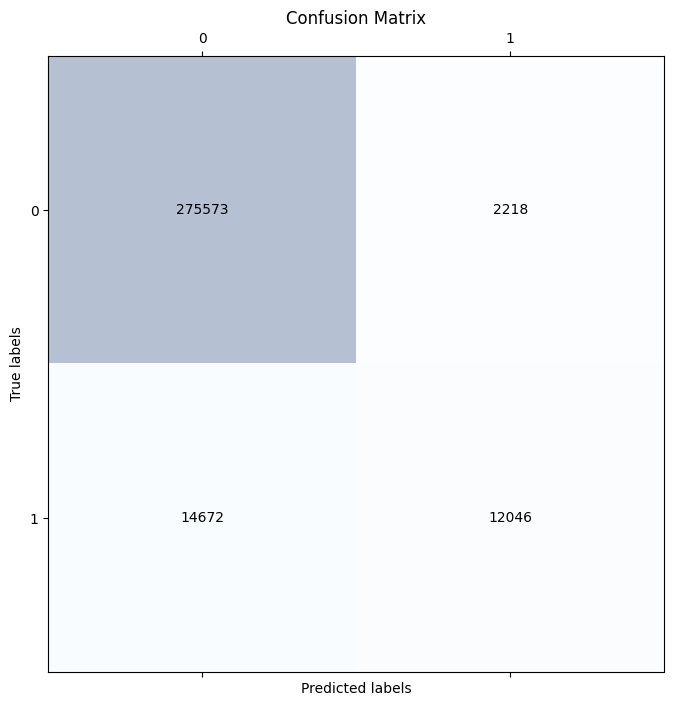

In [19]:
# Confusion Matrix 생성
conf_matrix = confusion_matrix(y_test, preds)

# Confusion Matrix 시각화
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Accuracy 계산
accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

# F1 Score 계산
f1 = f1_score(y_test, preds)
print("F1 Score:", f1)

Accuracy: 0.9445336591036718
F1 Score: 0.5878678444195011


PR Curve AUC: 0.71979473998669


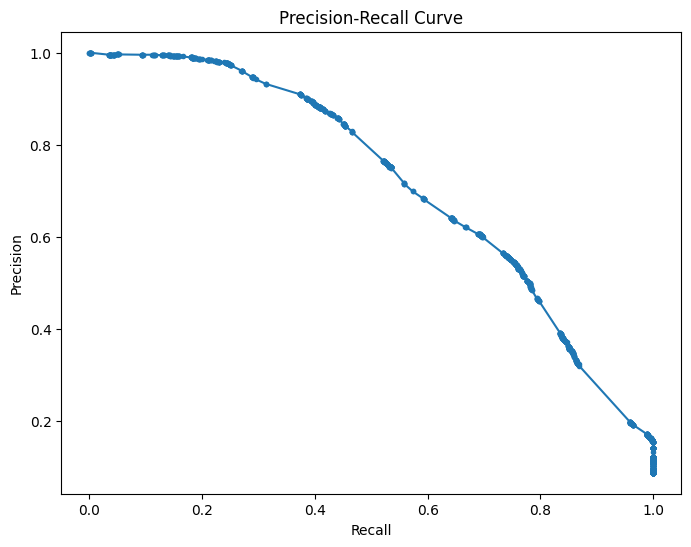

In [21]:
# Precision과 Recall 계산
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test.values)[:,1])

# PR Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# AUC 계산
pr_auc = auc(recall, precision)
print("PR Curve AUC:", pr_auc)